Carregando resultados da simulação principal...
-> Arquivo 'phase2_results.csv' carregado com sucesso!

📋 Tabela de Resumo Quantitativo (Média de Performance) 📋


condition,baseline_normal,high_skewness,outliers_10_percent,small_samples
gladiator,,,,
ANOVA,1.000,1.000,0.858,1.000
Kruskal-Wallis,1.000,1.000,1.000,0.999
RandomForest,0.999,0.999,0.999,1.000
XGBoost,0.985,0.984,0.974,0.951


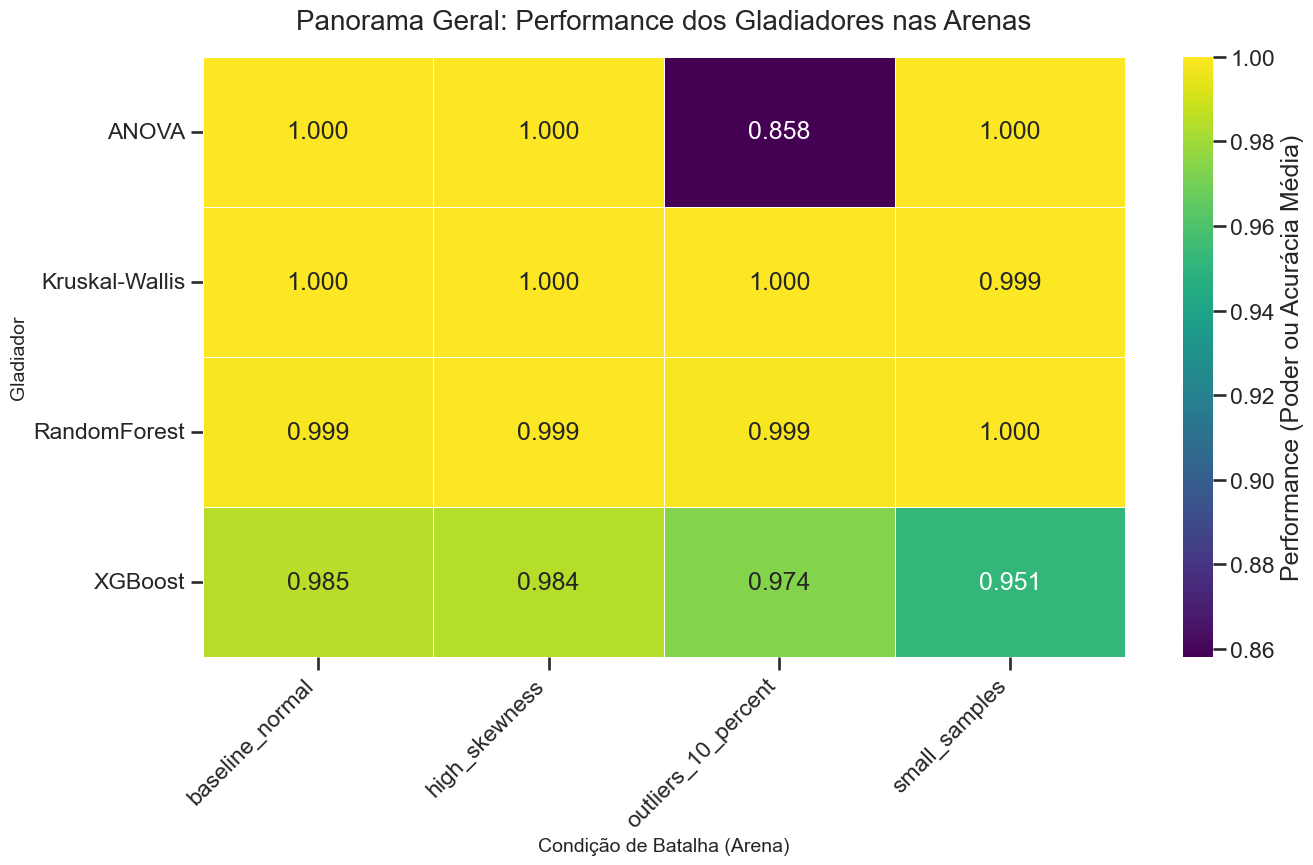

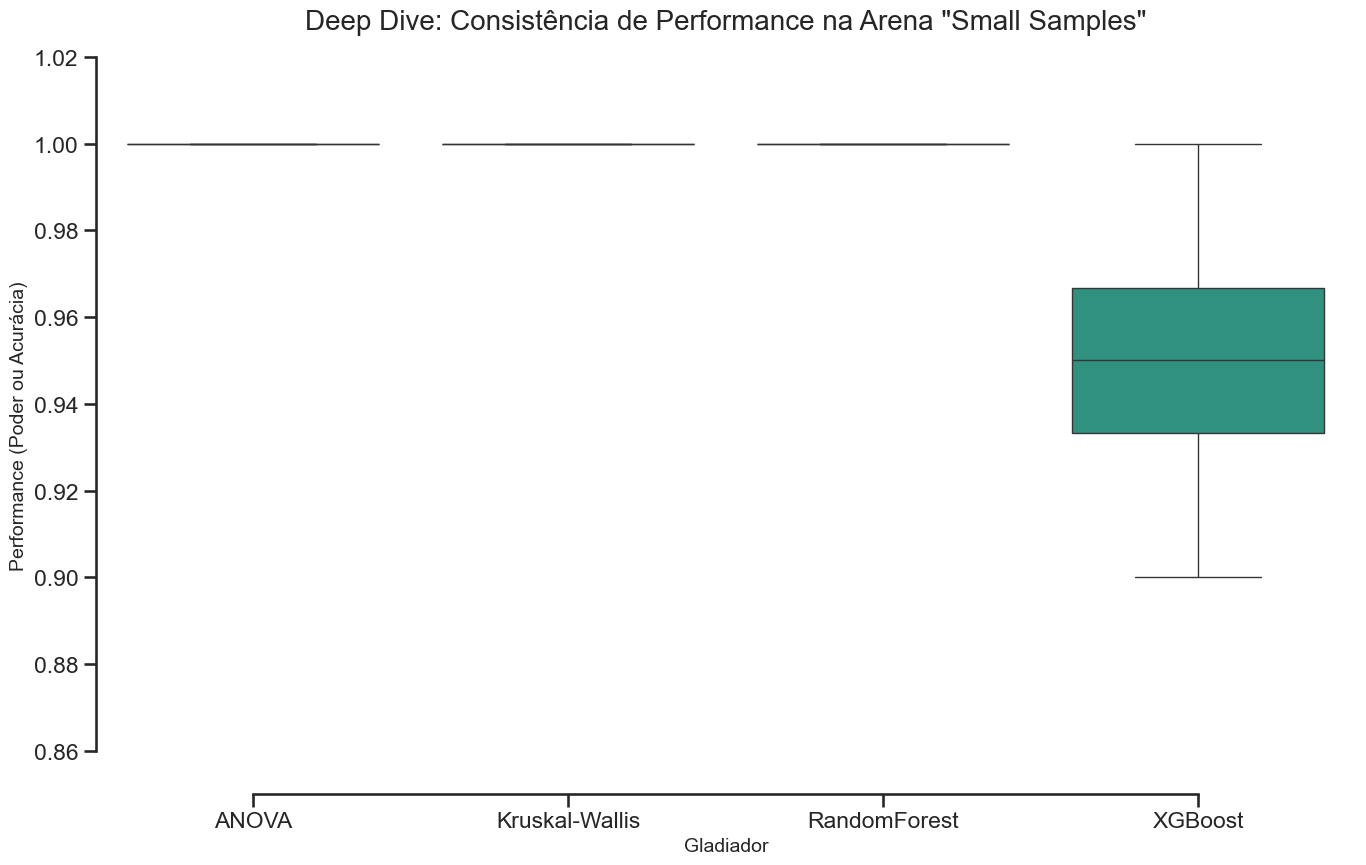


⚡ Executando Análise de Sensibilidade a Outliers...


  0%|          | 0/6 [00:00<?, ?it/s]

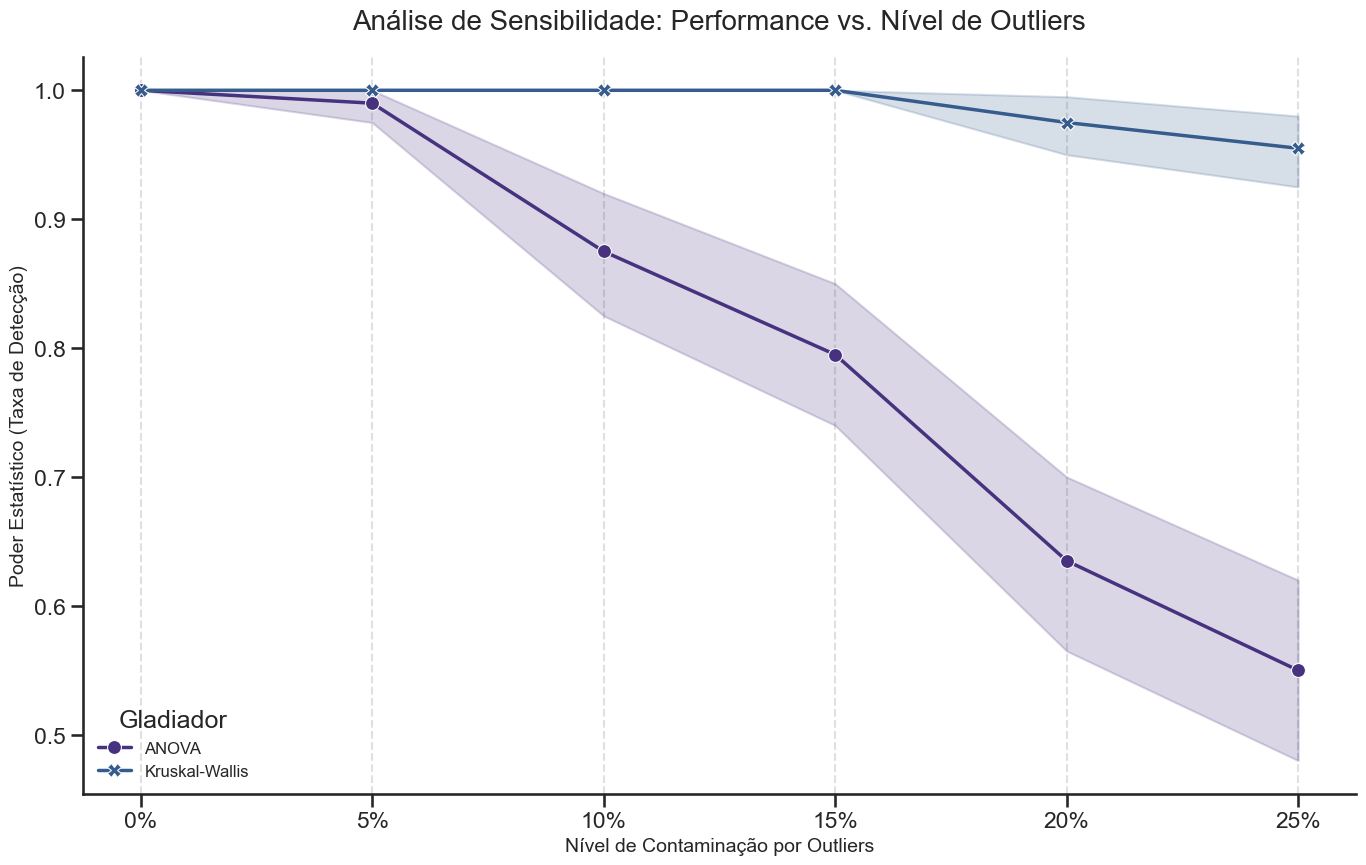

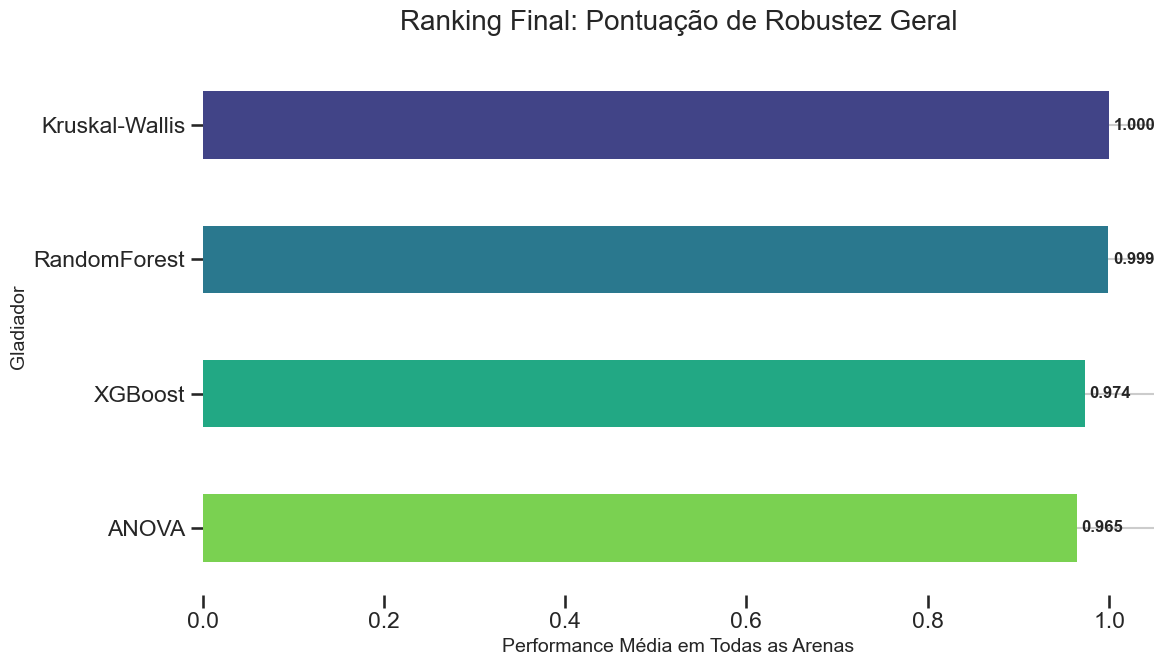


Análise final concluída. Todos os gráficos e tabelas foram gerados.


In [2]:
# ==============================================================================
# SCRIPT DE ANÁLISE E VISUALIZAÇÃO FINAL - PROJETO STATISTICAL GLADIATOR
# ==============================================================================

# --- Seção 1: Configuração, Bibliotecas e Carga de Dados ---

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from tqdm.notebook import tqdm
import warnings

# Ignorar warnings futuros do Seaborn para manter o output limpo
warnings.simplefilter(action='ignore', category=FutureWarning)

# Estilo profissional e acadêmico para todos os gráficos
plt.style.use('seaborn-v0_8-ticks')
sns.set_context("talk") # Aumenta o tamanho de fontes e linhas para melhor legibilidade
sns.set_palette("viridis")

print("Carregando resultados da simulação principal...")
try:
    results_df = pd.read_csv('phase2_results.csv')
    print("-> Arquivo 'phase2_results.csv' carregado com sucesso!")
except FileNotFoundError:
    print("-> ERRO: Arquivo 'phase2_results.csv' não encontrado. Rode o 'main_runner.py' primeiro.")
    # Encerra a execução se o arquivo não existir
    exit()

# --- Seção 2: Análise Quantitativa Avançada (Tabela com Intervalo de Confiança) ---

def get_performance_summary(data):
    """Calcula a média e o intervalo de confiança de 95% para uma série de dados."""
    if data.empty or data.isna().all():
        return np.nan, np.nan, np.nan
    mean = data.mean()
    # stats.sem calcula o erro padrão da média, tratando NaNs
    sem = stats.sem(data, nan_policy='omit')
    if sem > 0:
        # Graus de liberdade
        df = len(data.dropna()) - 1
        # Multiplicador t-student para o IC de 95%
        ci_margin = sem * stats.t.ppf((1 + 0.95) / 2., df)
        return mean, mean - ci_margin, mean + ci_margin
    else:
        return mean, mean, mean

summary_stats = []
for group_keys, group_df in results_df.groupby(['condition', 'gladiator']):
    condition, gladiator = group_keys
    
    metric_col = 'p_value' if 'p_value' in group_df.columns and group_df['p_value'].notna().any() else 'accuracy'
    
    if metric_col == 'p_value':
        performance_data = (group_df[metric_col] < 0.05).astype(float)
        metric_name = 'Power'
    else:
        performance_data = group_df[metric_col]
        metric_name = 'Avg. Accuracy'
        
    mean, ci_lower, ci_upper = get_performance_summary(performance_data)
    summary_stats.append({
        'condition': condition,
        'gladiator': gladiator,
        'metric': metric_name,
        'performance': mean,
        'ci_95_str': f"[{ci_lower:.3f}, {ci_upper:.3f}]" # IC como string para a tabela
    })

summary_df = pd.DataFrame(summary_stats)
summary_pivot = summary_df.pivot_table(index='gladiator', columns='condition', values='performance')

print("\n📋 Tabela de Resumo Quantitativo (Média de Performance) 📋")
display(summary_pivot.style.format("{:.3f}").background_gradient(cmap='viridis', axis=0))


# --- Seção 3: Visualizações Profissionais ---

# Gráfico 1: O Heatmap Principal (Panorama Geral)
fig, ax = plt.subplots(figsize=(14, 9))
sns.heatmap(
    summary_pivot, annot=True, fmt=".3f", cmap='viridis', linewidths=.5, ax=ax,
    cbar_kws={'label': 'Performance (Poder ou Acurácia Média)'}
)
ax.set_title('Panorama Geral: Performance dos Gladiadores nas Arenas', fontsize=20, pad=20)
ax.set_xlabel('Condição de Batalha (Arena)', fontsize=14)
ax.set_ylabel('Gladiador', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Gráfico 2: Boxplot Aprimorado (Deep Dive: Small Samples)
small_sample_df = results_df.loc[results_df['condition'] == 'small_samples'].copy()
small_sample_df['performance'] = np.where(small_sample_df['p_value'].notna(), 
                                          (small_sample_df['p_value'] < 0.05).astype(int), 
                                          small_sample_df['accuracy'])

fig, ax = plt.subplots(figsize=(14, 9))
sns.boxplot(data=small_sample_df, x='gladiator', y='performance', hue='gladiator', ax=ax, legend=False)
ax.set_title('Deep Dive: Consistência de Performance na Arena "Small Samples"', fontsize=20, pad=20)
ax.set_xlabel('Gladiador', fontsize=14)
ax.set_ylabel('Performance (Poder ou Acurácia)', fontsize=14)
ax.set_ylim(0.85, 1.02) # "Zoom" para destacar as diferenças
sns.despine(trim=True)
plt.tight_layout()
plt.show()

# Gráfico 3: Gráfico de Linhas (Análise de Sensibilidade a Outliers)
from simulation_engine import generate_battle_data # Reimportando para clareza

contamination_levels = np.linspace(0, 0.25, 6)
sensitivity_results = []
n_runs_per_level = 200

print(f"\n⚡ Executando Análise de Sensibilidade a Outliers...")
for level in tqdm(contamination_levels):
    for i in range(n_runs_per_level):
        df = generate_battle_data(n_groups=3, n_per_group=30, effect_size=0.8, contamination_level=level, random_state=i)
        
        _, p_anova = f_oneway(*[df['value'][df['group'] == g] for g in df['group'].unique()])
        sensitivity_results.append({'contamination': level, 'gladiator': 'ANOVA', 'power': p_anova < 0.05})
        
        _, p_kruskal = kruskal(*[df['value'][df['group'] == g] for g in df['group'].unique()])
        sensitivity_results.append({'contamination': level, 'gladiator': 'Kruskal-Wallis', 'power': p_kruskal < 0.05})

sensitivity_df = pd.DataFrame(sensitivity_results)

fig, ax = plt.subplots(figsize=(14, 9))
sns.lineplot(data=sensitivity_df, x='contamination', y='power', hue='gladiator', style='gladiator', 
             markers=True, dashes=False, ax=ax, errorbar='ci', markersize=10, linewidth=2.5)
ax.set_title('Análise de Sensibilidade: Performance vs. Nível de Outliers', fontsize=20, pad=20)
ax.set_xlabel('Nível de Contaminação por Outliers', fontsize=14)
ax.set_ylabel('Poder Estatístico (Taxa de Detecção)', fontsize=14)
ax.set_xticks(contamination_levels)
ax.set_xticklabels([f'{x:.0%}' for x in contamination_levels])
ax.legend(title='Gladiador', fontsize=12)
ax.grid(axis='x', linestyle='--', alpha=0.6)
sns.despine()
plt.tight_layout()
plt.show()

# Gráfico 4: Ranking Final (Gráfico de Barras Aprimorado)
robustness_score = summary_pivot.mean(axis=1).sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(12, 7))
robustness_score.plot(kind='barh', ax=ax, color=sns.color_palette('viridis', n_colors=len(robustness_score)))
ax.set_title('Ranking Final: Pontuação de Robustez Geral', fontsize=20, pad=20)
ax.set_xlabel('Performance Média em Todas as Arenas', fontsize=14)
ax.set_ylabel('Gladiador', fontsize=14)
ax.invert_yaxis() # Coloca o melhor no topo
ax.grid(axis='y')

# Adiciona os valores no final das barras
for index, value in enumerate(robustness_score):
    ax.text(value + 0.005, index, f'{value:.3f}', va='center', ha='left', fontsize=12, fontweight='bold')
    
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()

print("\nAnálise final concluída. Todos os gráficos e tabelas foram gerados.")